In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.nn.nets import ResidualNet
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform

In [2]:
checkpoint = torch.load('dataset.pt')
theta_vals = checkpoint['theta_vals']
data_vals = checkpoint['data_vals']
parameters = checkpoint['parameters']

In [3]:
len(theta_vals)

6000

In [23]:
class DataGenerator(Dataset):
    def __len__(self):
        return 4000

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

In [24]:
dataset = DataGenerator()

In [25]:
dataset = DataGenerator()

# create dataloaders - 80/10/10 split
train_set_size = int(0.8 * 4000)
val_set_size = int(0.1 * 4000)
test_set_size = int(0.1 * 4000)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

train_data_loader = DataLoader(
    train_data, batch_size=256,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=256,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [28]:
num_transforms = 24
num_blocks = 24
hidden_features = 50

context_features = data_vals[0].shape[0]
parameter_space_dim = len(parameters)

base_dist = StandardNormal([parameter_space_dim])  

transforms = []

for _ in range(num_transforms):
    block = [
        MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
            features=parameter_space_dim,
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            tails='linear',          # You can also try 'circular' or 'constant' if desired
            tail_bound=3.0,          # Adjust as needed; default 3.0 is common
            num_bins=8,              # Number of bins for the spline, common: 8~16
            dropout_probability=0.0, # Adjust if you want dropout
            activation=torch.tanh,
            use_batch_norm=True,
            use_residual_blocks=False,
        ),
        RandomPermutation(features=parameter_space_dim)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [29]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [30]:
for i in range(200):
    flow.train()
    train_loss_total = 0.0

    train_loader = tqdm(train_data_loader, desc=f"Epoch {i+1} [Train]", leave=False)
    for idx, val in enumerate(train_loader):
        theta, data = val
        theta = theta.to(device)
        data = data.to(device)

        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).mean()
        loss.backward()
        optimizer.step()
        
        train_loss_total += loss.item()
        train_loader.set_postfix(loss=loss.item())

    scheduler.step()
    train_loss_avg = train_loss_total / len(train_data_loader)

    flow.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        val_loader = tqdm(val_data_loader, desc=f"Epoch {i+1} [Val]", leave=False)
        for idx, val in enumerate(val_loader):
            theta, data = val
            theta = theta.to(device)
            data = data.to(device)

            val_loss_batch = -flow.log_prob(theta, context=data).mean()
            val_loss_total += val_loss_batch.item()
            val_loader.set_postfix(loss=val_loss_batch.item())

    val_loss_avg = val_loss_total / len(val_data_loader)

    if i == 0 or (i+1) % 10 == 0:
        print(f"[Epoch {i+1}] Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")

[Epoch 1] Train Loss: 1230383.4904 | Val Loss: 1122644.0000


KeyboardInterrupt: 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

# --- Load Data ---
# Assuming 'dataset.pt' is in the same directory
try:
    checkpoint = torch.load('dataset.pt')
    theta_vals_raw = checkpoint['theta_vals']
    data_vals = checkpoint['data_vals']
    parameters = checkpoint['parameters']
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'dataset.pt' not found. Please create a dummy dataset for testing.")
    # Create dummy data if the file doesn't exist, for script portability
    theta_vals_raw = torch.randn(4000, 11)
    data_vals = torch.randn(4000, 1024) # Assuming some context feature size
    parameters = [f'param_{i}' for i in range(11)]


# --- FIX 1: Data Scaling (Crucial for good performance) ---
# Normalizing flows, like most neural networks, train best when input features
# are on a similar scale (e.g., standard normal distribution).
# Since your parameters have different orders of magnitude, scaling is essential.

# We will fit the scaler ONLY on the training data to prevent data leakage.
train_set_size = int(0.8 * len(theta_vals_raw))
val_set_size = int(0.1 * len(theta_vals_raw))
test_set_size = len(theta_vals_raw) - train_set_size - val_set_size

# Create indices for splitting
indices = torch.randperm(len(theta_vals_raw))
train_indices = indices[:train_set_size]
val_indices = indices[train_set_size:train_set_size + val_set_size]
test_indices = indices[train_set_size + val_set_size:]

# Fit scaler ONLY on the training subset of theta
scaler = StandardScaler()
scaler.fit(theta_vals_raw[train_indices])

# Now apply the transformation to all theta values
theta_vals_scaled = torch.from_numpy(scaler.transform(theta_vals_raw)).float()

# --- REFACTOR 2: More Robust Dataset Class ---
class GWDataset(Dataset):
    """A more robust Dataset that isn't hardcoded."""
    def __init__(self, theta, data):
        self.theta = theta
        self.data = data

    def __len__(self):
        return self.theta.shape[0]

    def __getitem__(self, idx):
        return self.theta[idx], self.data[idx]

# Create the full dataset with scaled theta values
full_dataset = GWDataset(theta_vals_scaled, data_vals)

# Use the pre-defined indices to create non-random splits
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)
test_data = Subset(full_dataset, test_indices)

# Create DataLoaders
train_data_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# --- Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- SUGGESTION 3: Model Configuration and Hyperparameters ---
# It's good practice to group hyperparameters.
# A 24-layer flow is very deep and can be slow to train and prone to overfitting.
# Starting with a smaller model (e.g., 10-12 transforms) is often better for faster iteration.
model_config = {
    'num_transforms': 12,
    'num_blocks_per_transform': 12, # Renamed from num_blocks for clarity
    'hidden_features': 50,
    'tail_bound': 3.0,
    'num_bins': 8,
    'dropout_probability': 0.0,
    'use_batch_norm': True,
}

context_features = data_vals.shape[1]
parameter_space_dim = len(parameters)

base_dist = StandardNormal([parameter_space_dim])

# A cleaner way to build the transforms list
transforms = []
for _ in range(model_config['num_transforms']):
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=parameter_space_dim,
        hidden_features=model_config['hidden_features'],
        context_features=context_features,
        num_blocks=model_config['num_blocks_per_transform'],
        tails='linear',
        tail_bound=model_config['tail_bound'],
        num_bins=model_config['num_bins'],
        dropout_probability=model_config['dropout_probability'],
        use_batch_norm=model_config['use_batch_norm'],
    ))
    transforms.append(RandomPermutation(features=parameter_space_dim))

transform = CompositeTransform(transforms)
flow = Flow(transform, base_dist).to(device)

# --- Training Configuration ---
train_config = {
    'epochs': 100,
    'learning_rate': 1e-4,
    'scheduler_gamma': 0.98,
    'weight_decay': 1e-6 # FIX 4: Add weight decay for regularization
}

optimizer = torch.optim.Adam(
    flow.parameters(),
    lr=train_config['learning_rate'],
    weight_decay=train_config['weight_decay'] # Helps prevent overfitting
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=train_config['scheduler_gamma'])

print("Starting training...")
for i in range(train_config['epochs']):
    # --- Training Loop ---
    flow.train()
    train_loss_total = 0.0
    train_loader = tqdm(train_data_loader, desc=f"Epoch {i+1} [Train]", leave=False)

    for theta, data in train_loader:
        theta = theta.to(device)
        data = data.to(device)

        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).mean()
        
        # Check for NaN loss
        if torch.isnan(loss):
            print("Warning: NaN loss detected. Skipping batch.")
            continue
            
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()
        train_loader.set_postfix(loss=f'{loss.item():.4f}')

    scheduler.step()
    train_loss_avg = train_loss_total / len(train_data_loader)

    # --- Validation Loop ---
    flow.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        val_loader = tqdm(val_data_loader, desc=f"Epoch {i+1} [Val]", leave=False)
        for theta, data in val_loader:
            theta = theta.to(device)
            data = data.to(device)

            val_loss_batch = -flow.log_prob(theta, context=data).mean()
            val_loss_total += val_loss_batch.item()
            val_loader.set_postfix(loss=f'{val_loss_batch.item():.4f}')

    val_loss_avg = val_loss_total / len(val_data_loader)

    if i == 0 or (i + 1) % 5 == 0:
        print(f"[Epoch {i+1:03d}/{train_config['epochs']}] Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")

print("Training finished.")

# --- SUGGESTION 5: Save the Model and Scaler ---
# It's crucial to save both the trained flow and the scaler object.
# The scaler is needed to transform new data or to inverse_transform samples.
torch.save(flow.state_dict(), 'gw_flow_model.pth')
with open('theta_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved.")

Dataset loaded successfully.
Using device: cuda
Starting training...


[Epoch 001/100] Train Loss: 21.8666 | Val Loss: 20.8839


[Epoch 005/100] Train Loss: 16.1728 | Val Loss: 16.7534


[Epoch 010/100] Train Loss: 14.8496 | Val Loss: 15.8111


[Epoch 015/100] Train Loss: 14.1889 | Val Loss: 15.3822


[Epoch 020/100] Train Loss: 13.8593 | Val Loss: 15.1632


[Epoch 025/100] Train Loss: 13.5574 | Val Loss: 15.0487


[Epoch 030/100] Train Loss: 13.3549 | Val Loss: 15.1201


[Epoch 035/100] Train Loss: 13.1399 | Val Loss: 14.9272


[Epoch 040/100] Train Loss: 12.9994 | Val Loss: 14.9526


[Epoch 045/100] Train Loss: 12.8811 | Val Loss: 14.9317


[Epoch 050/100] Train Loss: 12.7479 | Val Loss: 14.9389


[Epoch 055/100] Train Loss: 12.6802 | Val Loss: 15.0332


[Epoch 060/100] Train Loss: 12.5843 | Val Loss: 14.9849


[Epoch 065/100] Train Loss: 12.4946 | Val Loss: 14.9826


[Epoch 070/100] Train Loss: 12.4062 | Val Loss: 15.0158


[Epoch 075/100] Train Loss: 12.3356 | Val Loss: 15.0197


[Epoch 080/100] Train Loss: 12.3138 | Val Loss: 15.0922


[Epoch 085/100] Train Loss: 12.2448 | Val Loss: 15.0929


[Epoch 090/100] Train Loss: 12.1969 | Val Loss: 15.0704


[Epoch 095/100] Train Loss: 12.1122 | Val Loss: 15.0659


[Epoch 100/100] Train Loss: 12.0957 | Val Loss: 15.1049
Training finished.
Model and scaler saved.


In [2]:
# --- SUGGESTION 6: Evaluation on Test Set ---
# After training, you should evaluate the model's performance on unseen test data.
# A common way to do this is to generate posterior samples and create a corner plot.

print("\nEvaluating on a sample from the test set...")
flow.eval()
with torch.no_grad():
    # Get a single item from the test set
    test_theta_true, test_data_context = next(iter(test_data_loader))
    test_data_context = test_data_context.to(device)

    # Generate posterior samples from the flow
    # The context (the GW data) is fixed
    num_samples = 5000
    samples_scaled = flow.sample(num_samples, context=test_data_context).cpu().numpy()
    
    # Squeeze the context dimension if it exists
    if samples_scaled.ndim == 3:
        samples_scaled = samples_scaled.squeeze(0)

    # IMPORTANT: Inverse transform the samples back to the original parameter space
    samples_unscaled = scaler.inverse_transform(samples_scaled)

    print(f"Generated {num_samples} posterior samples.")
    print("True (scaled) parameters for this test case:")
    print(test_theta_true.numpy())


Evaluating on a sample from the test set...
Generated 5000 posterior samples.
True (scaled) parameters for this test case:
[[-1.7602257  -1.0998861   0.41247818  0.04463318  1.376758    1.0847355
   1.195884   -0.47387487 -0.71910936  1.190114    0.49734005]]


Saved corner plot to posterior_corner_plot_NSF.pdf


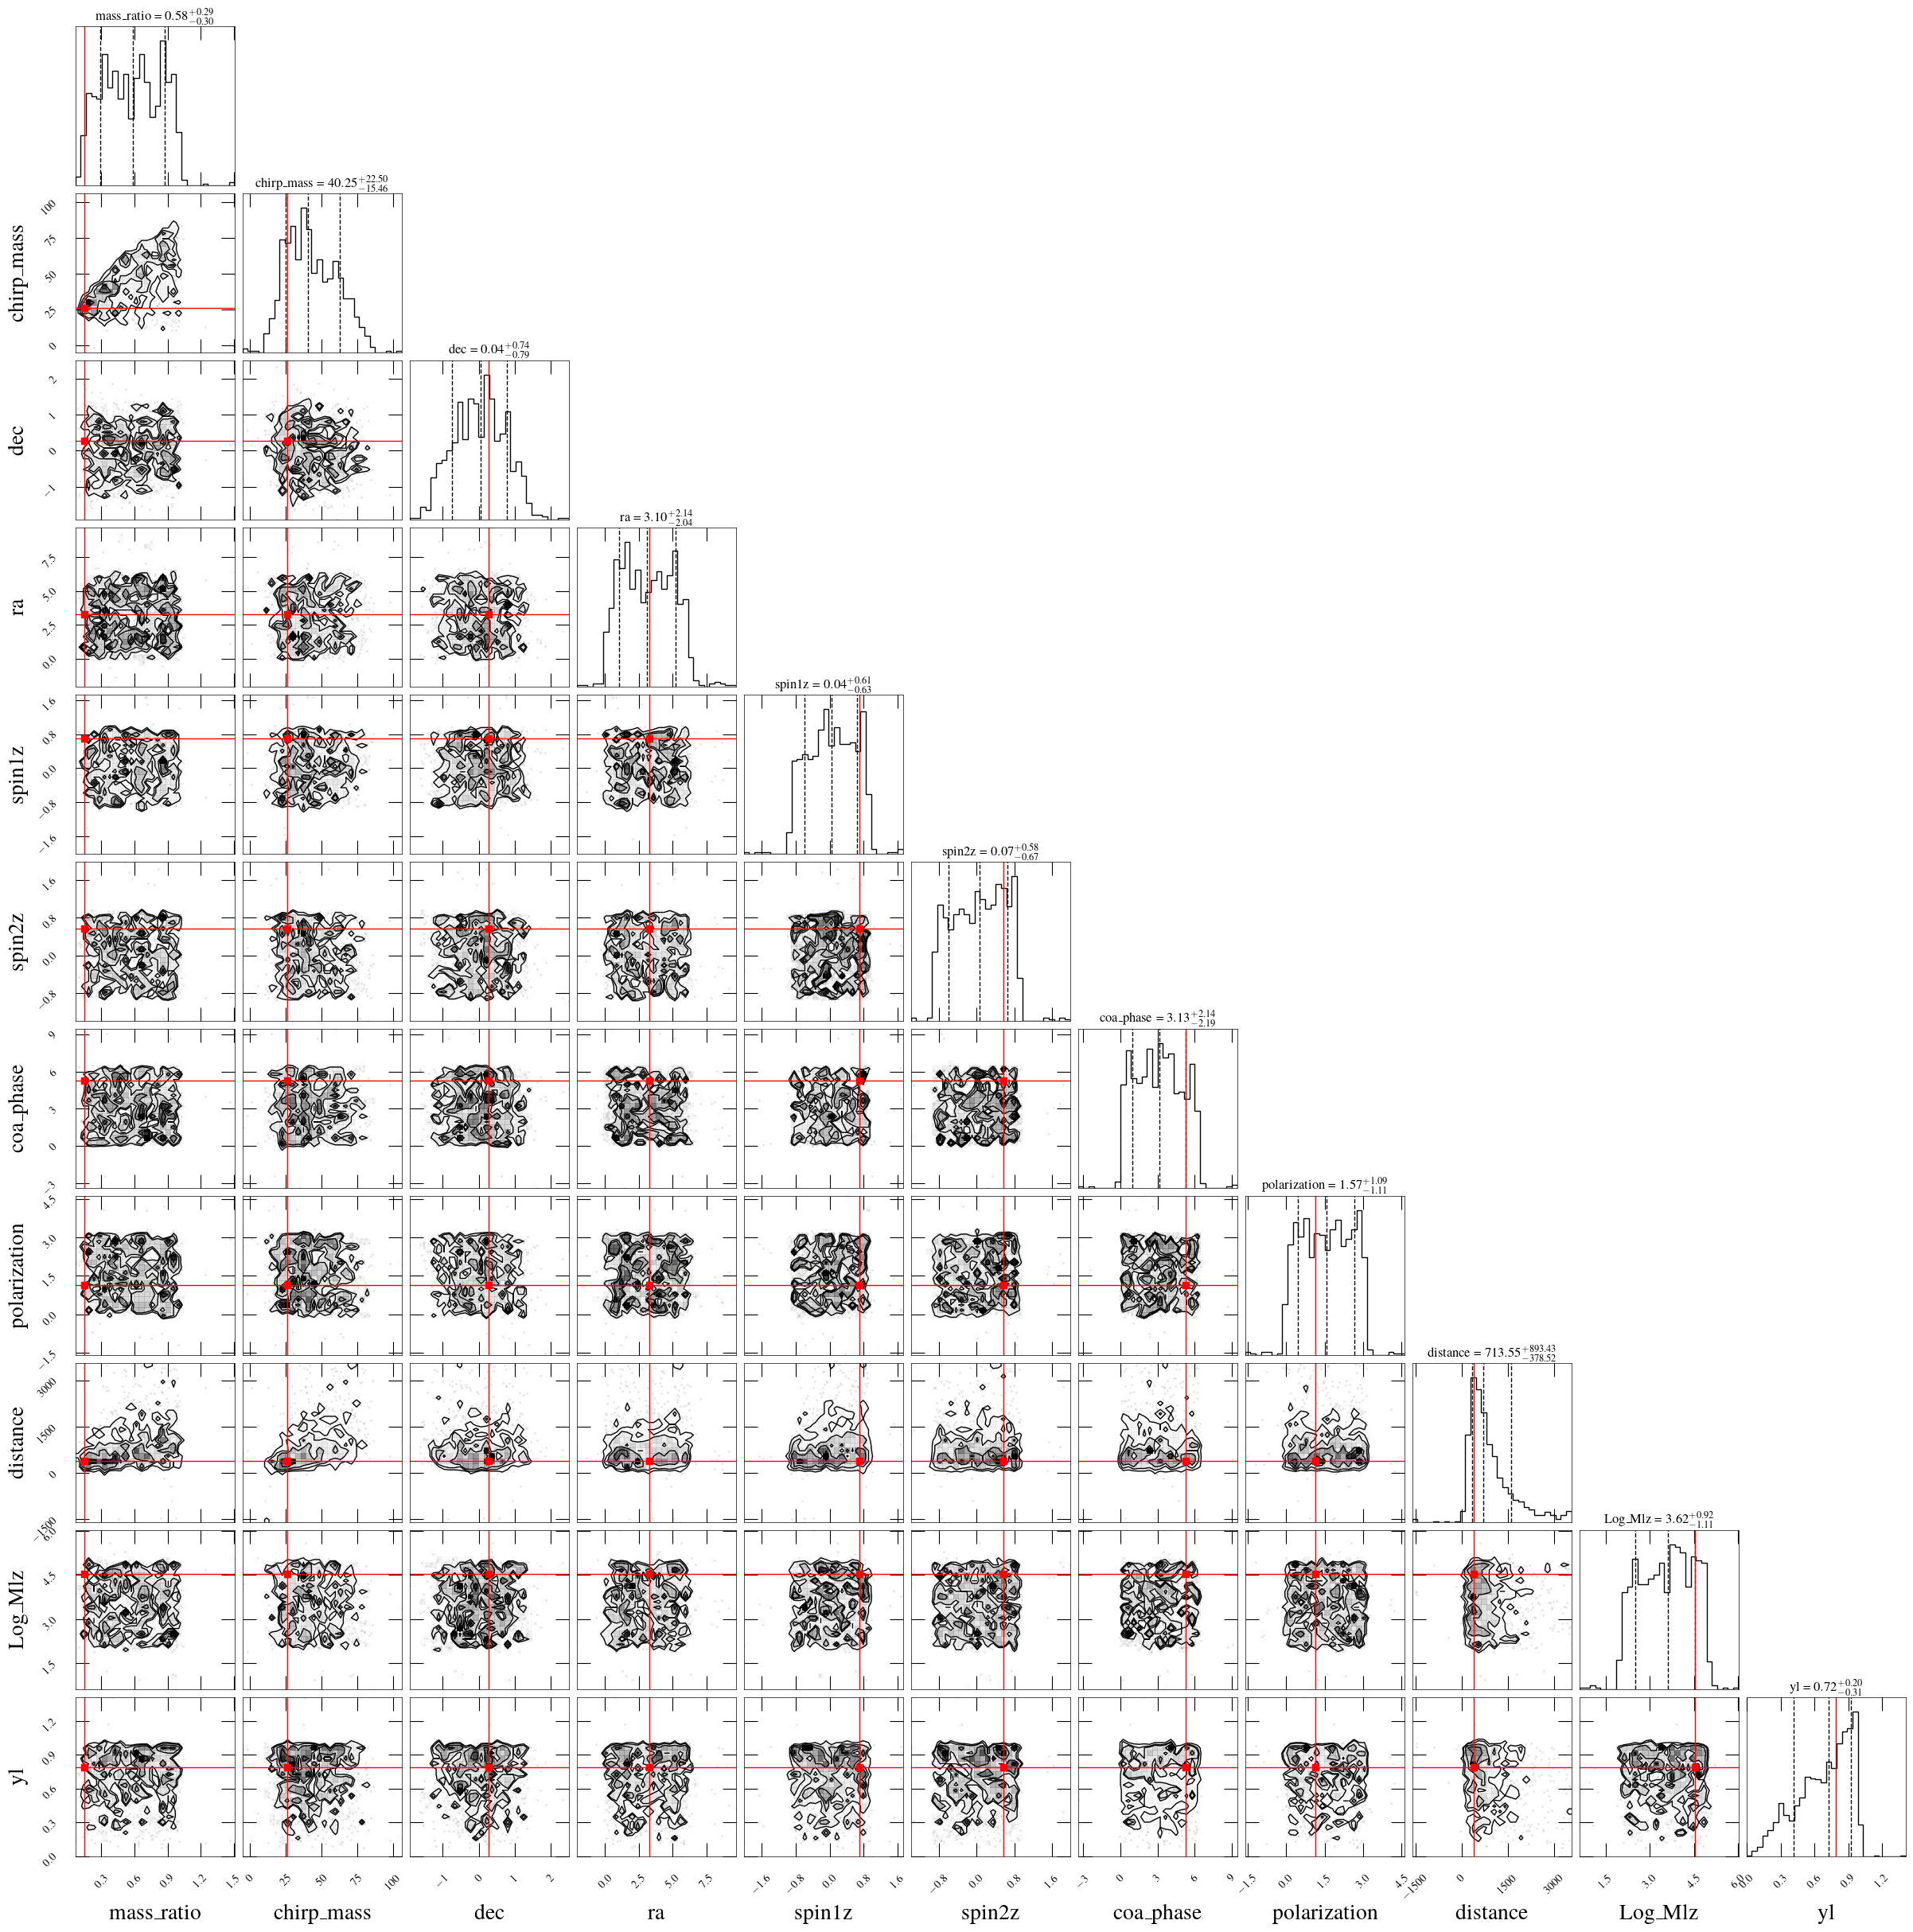

In [8]:
import corner
fig = corner.corner(
    samples_unscaled,
    bins=30,
    labels=parameters,
    truths=scaler.inverse_transform(test_theta_true.numpy())[0], # unscale the true value
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truth_color="red",
)
plt.savefig("posterior_corner_plot_NSF.pdf")
print("Saved corner plot to posterior_corner_plot_NSF.pdf")

In [9]:
from scipy import stats
from matplotlib import rc

# --- Matplotlib Configuration ---
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=20)
rc("axes", linewidth=0.5)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)
rc('legend', fontsize=10)
rc('ytick', right=True, direction='in')
rc('xtick', top=True, direction='in')
rc('xtick.major', pad=15)
rc('ytick.major', pad=15)
rc('xtick.major', size=12)
rc('ytick.major', size=12)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)

# --- Plotting Functions ---
def set_tick_sizes(ax, major=12, minor=7):
    for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        line.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)

def plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95):
    """Generates an overlay P-P plot for multiple parameters."""
    n_tests = pp_values.shape[0]

    # Calculate 95% CI
    alpha = 1 - confidence_level
    alpha_lower_bound = stats.beta.ppf(alpha/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)
    alpha_upper_bound = stats.beta.ppf(1 - alpha/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)

    # Calculate 99% CI
    beta = 1 - 0.99
    beta_lower_bound = stats.beta.ppf(beta/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)
    beta_upper_bound = stats.beta.ppf(1 - beta/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    set_tick_sizes(ax)

    # Expected quantiles
    expected_quantiles = np.linspace(0, 1, n_tests)

    # Colors for different parameters
    colors = plt.cm.tab20(np.linspace(0, 1, len(parameter_names)))

    # Plot each parameter
    for i, param_name in enumerate(parameter_names):
        sorted_pp = np.sort(pp_values[:, i])
        # Use a more descriptive label if parameter names are generic
        label = param_name.replace('_', ' ').title() if 'param' in param_name else param_name
        ax.plot(expected_quantiles, sorted_pp, color=colors[i], linewidth=2,
                label=label, alpha=0.8)

    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')

    # Fill 99% CI first (lighter)
    ax.fill_between(expected_quantiles, beta_lower_bound, beta_upper_bound,
                    alpha=0.1, color='gray', label='99\% CI')

    # Fill 95% CI on top (darker)
    ax.fill_between(expected_quantiles, alpha_lower_bound, alpha_upper_bound,
                    alpha=0.2, color='gray', label=f'{confidence_level*100:.0f}\% CI')

    # Labels and styling
    ax.set_xlabel('Expected quantile', fontsize=12)
    ax.set_ylabel('Observed quantile', fontsize=12)
    ax.set_title('P-P Plot for Model Calibration', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig('QQ_Neural_Spline_Flow.pdf')
    plt.show()



Calculating P-P values for the entire test set...


P-P Plot Calculation: 100%|██████████| 600/600 [21:31<00:00,  2.15s/it]


P-P value calculation complete. Generating plot...


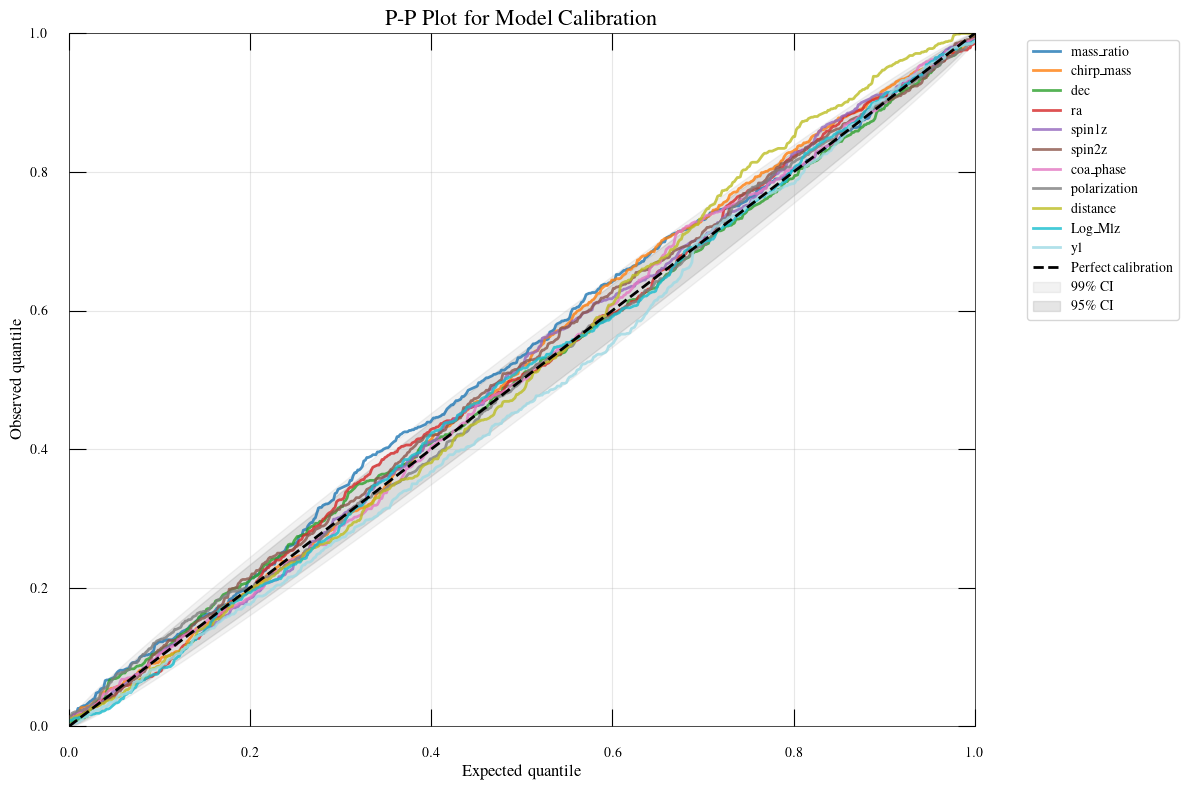

In [5]:

# --- P-P Plot Generation (Full Test Set Evaluation) ---
print("\nCalculating P-P values for the entire test set...")
all_pp_values = []
flow.eval()
with torch.no_grad():
    # Loop over the entire test set
    for theta_true_scaled, data_context in tqdm(test_data_loader, desc="P-P Plot Calculation"):
        data_context = data_context.to(device)
        
        # Generate posterior samples
        samples_scaled = flow.sample(1000, context=data_context).cpu().numpy().squeeze(0)
        
        # Inverse transform both samples and true values to original scale
        samples_unscaled = scaler.inverse_transform(samples_scaled)
        theta_true_unscaled = scaler.inverse_transform(theta_true_scaled.numpy())
        
        # Calculate P-P value for each parameter for this one sample
        # This is the fraction of posterior samples less than the true value
        pp_vals_sample = (samples_unscaled < theta_true_unscaled).mean(axis=0)
        all_pp_values.append(pp_vals_sample)

# Convert list of arrays to a single numpy array
all_pp_values = np.array(all_pp_values)

print("P-P value calculation complete. Generating plot...")
plot_overlay_pp_plot(all_pp_values, parameters)


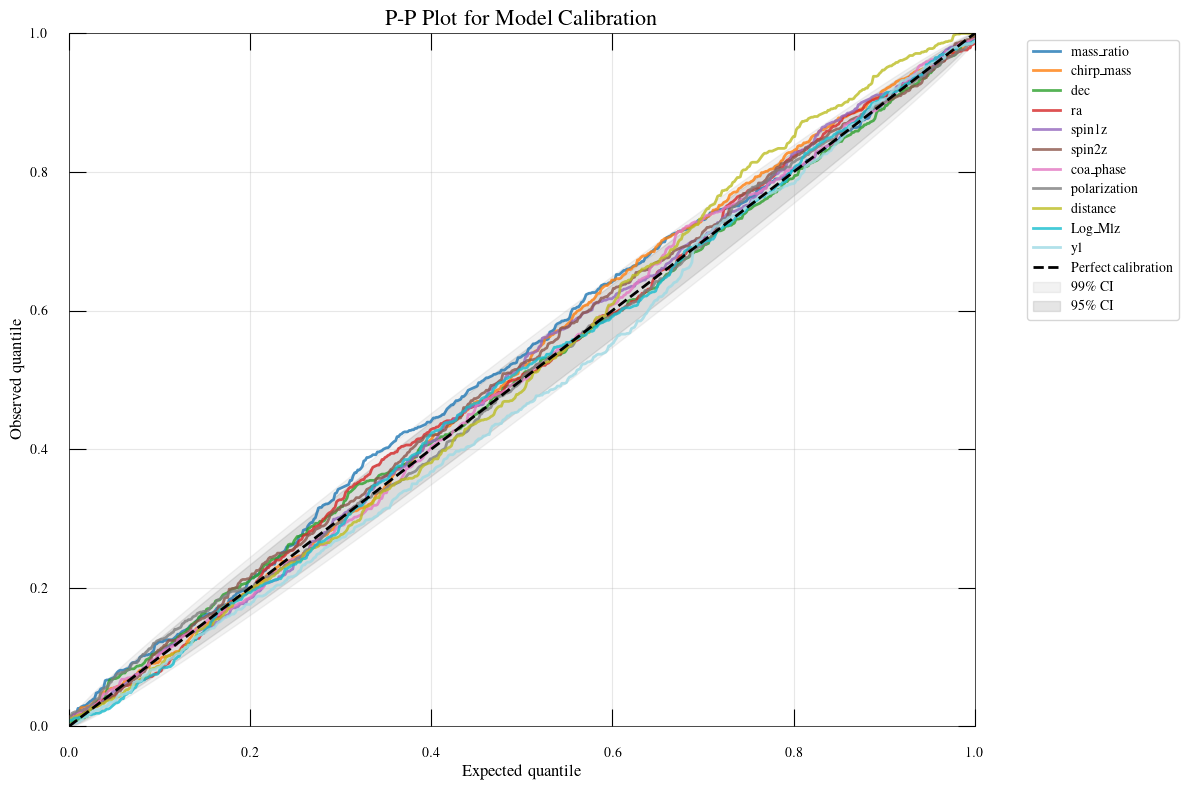

In [10]:
plot_overlay_pp_plot(all_pp_values, parameters)